In [1]:
import torch
# import torch.nn as nn
# from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np
import pmath

# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# with open('input.txt', 'r', encoding='utf-8') as f:
#     text = f.read()

# import importlib # for updating .py scripts

# import os
# from torch.utils.data import DataLoader, Dataset
# from model_hyperbolic import GPT, GPTConfig  

### Experiments

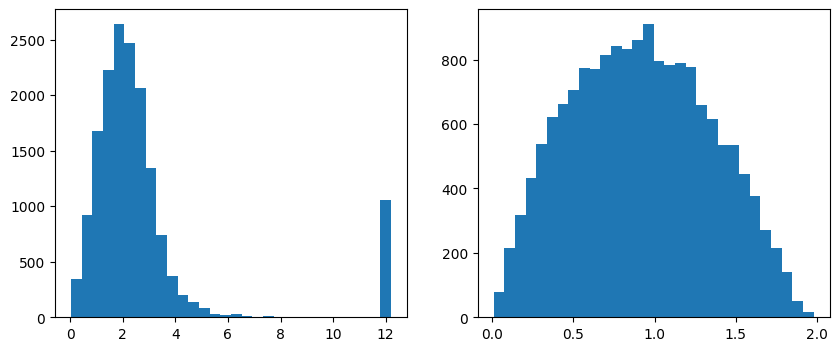

In [2]:
def sample_unit_ball(batch_shape, d):
    points = torch.randn(*batch_shape, d)
    
    norm = torch.norm(points, dim=-1, keepdim=True)
    unit_sphere_points = points / norm
    
    radius = torch.rand(*batch_shape, 1) ** (1.0 / d)
    unit_ball_points = unit_sphere_points * radius
    
    return unit_ball_points

batch_shape = (16, 32)
d = 2 

x = sample_unit_ball(batch_shape, d)
y = sample_unit_ball(batch_shape, d)
c = 1.
px = pmath.expmap0(x, c=c)
py = pmath.expmap0(y, c=c)

hyp_distances = pmath.dist_matrix(px, py)
euc_distances = torch.cdist(x, y)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(hyp_distances.numpy().flatten(), bins=30)
ax2.hist(euc_distances.numpy().flatten(), bins=30)
plt.show()

### Distance VS Curvature in dim = 2

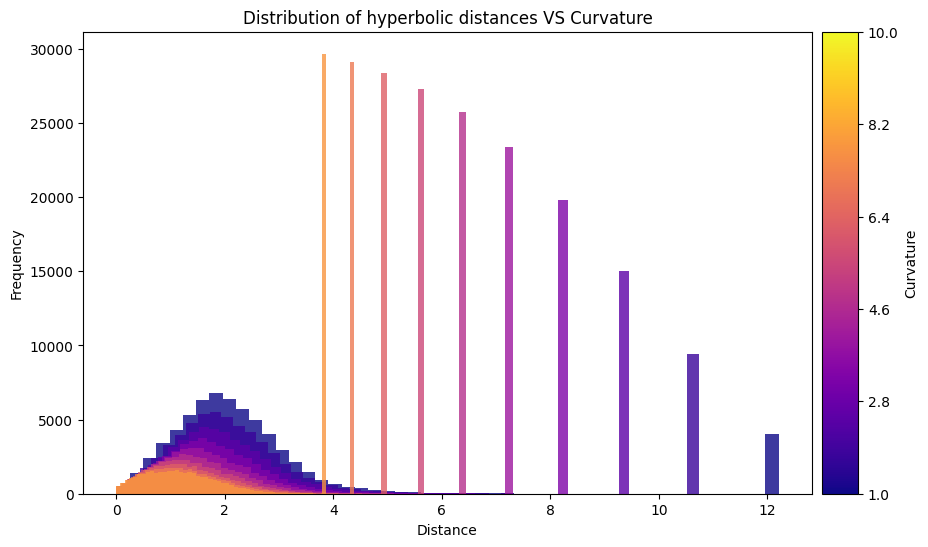

In [15]:
B, T, C = 16, 64, 2 

x_euc = sample_unit_ball((B, T), C)
y_euc = sample_unit_ball((B, T), C)

curvatures = np.logspace(0., 1., 10)

distances = {}
for c in curvatures:
    x = pmath.expmap0(x_euc, c=c)  
    y = pmath.expmap0(y_euc, c=c)  
    distances[c] = pmath.dist_matrix(x, y, c=c).view(-1).cpu().numpy()

n = len(curvatures)
colors = plt.cm.plasma(np.linspace(0.75, 0., n))[::-1]

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

for c, dists, color in zip(distances.keys(), distances.values(), colors):
    ax.hist(dists, bins=50, alpha=0.8, label=f'c={c:.2f}', color=color, density=False)

ax.set_title('Distribution of hyperbolic distances VS Curvature')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')

# Create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be 0.05 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Create a ScalarMappable with the same colormap and normalization as the plot
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(curvatures), vmax=max(curvatures)))
sm.set_array([])  # You need to set_array for ScalarMappable.

# Add colorbar using the ScalarMappable and the specific axes for the colorbar
cbar = fig.colorbar(sm, cax=cax, ticks=np.linspace(min(curvatures), max(curvatures), num=6))
# cbar.set_ticklabels([f'{c:.2f}' for c in np.linspace(min(curvatures), max(curvatures), num=min(n, 10))])
cbar.set_label('Curvature', x = 0.5)

# ax.legend()
# plt.savefig('1to30.jpg')
plt.show()

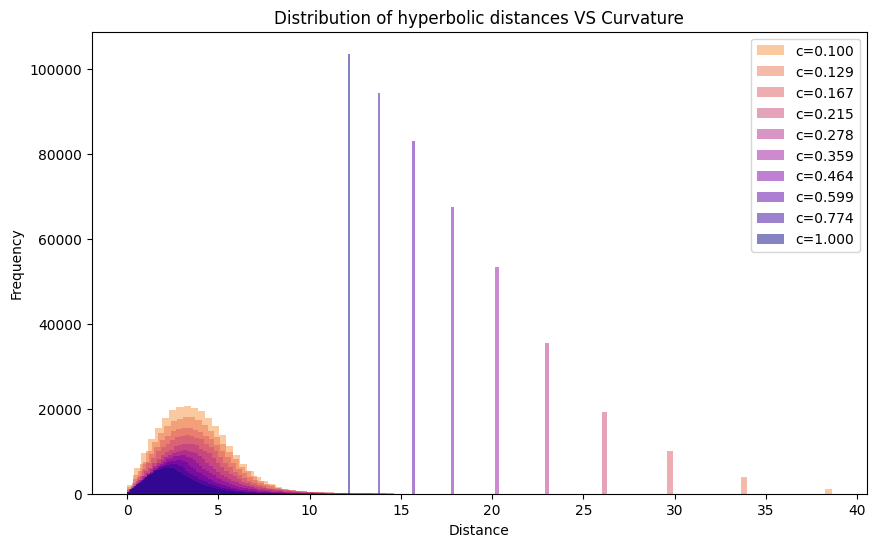

In [13]:
B, T, C = 64, 64, 2

curvatures = np.logspace(-1, 0, 10)

distances = {}
for c in curvatures:
    x = pmath.expmap0(torch.randn(B, T, C), c=c)  
    y = pmath.expmap0(torch.randn(B, T, C), c=c)  
    distances[c] = pmath.dist_matrix(x, y, c=c).view(-1).cpu().numpy()

n = len(curvatures)
colors = cmap = plt.cm.plasma(np.linspace(0.75, 0., n))

plt.figure(figsize=(10, 6))
for c, dists, color in zip(distances.keys(), distances.values(), colors):
    plt.hist(dists, bins=100, alpha=0.5, label=f'c={c:.3f}', color=color, density=False)
plt.title('Distribution of hyperbolic distances VS Curvature')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('out/corrected_distributions.jpg')
plt.show()

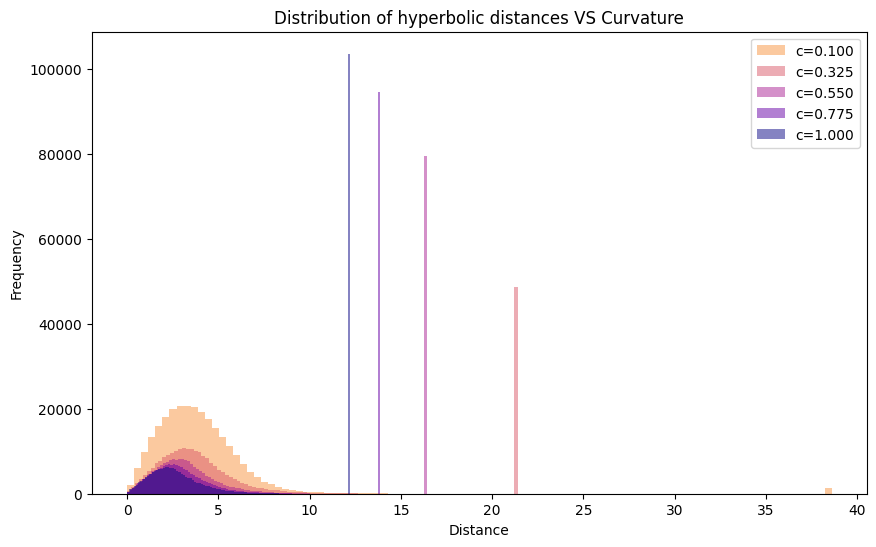

In [14]:
B, T, C = 64, 64, 2

curvatures = np.linspace(0.1, 1., 5)

distances = {}
for c in curvatures:
    x = pmath.expmap0(torch.randn(B, T, C), c=c)  
    y = pmath.expmap0(torch.randn(B, T, C), c=c)  
    distances[c] = pmath.dist_matrix(x, y, c=c).view(-1).cpu().numpy()

n = len(curvatures)
colors = cmap = plt.cm.plasma(np.linspace(0.75, 0., n))

plt.figure(figsize=(10, 6))
for c, dists, color in zip(distances.keys(), distances.values(), colors):
    plt.hist(dists, bins=100, alpha=0.5, label=f'c={c:.3f}', color=color, density=False)
plt.title('Distribution of hyperbolic distances VS Curvature')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('amplitudes_over1.jpg')
plt.show()

### dim > 2

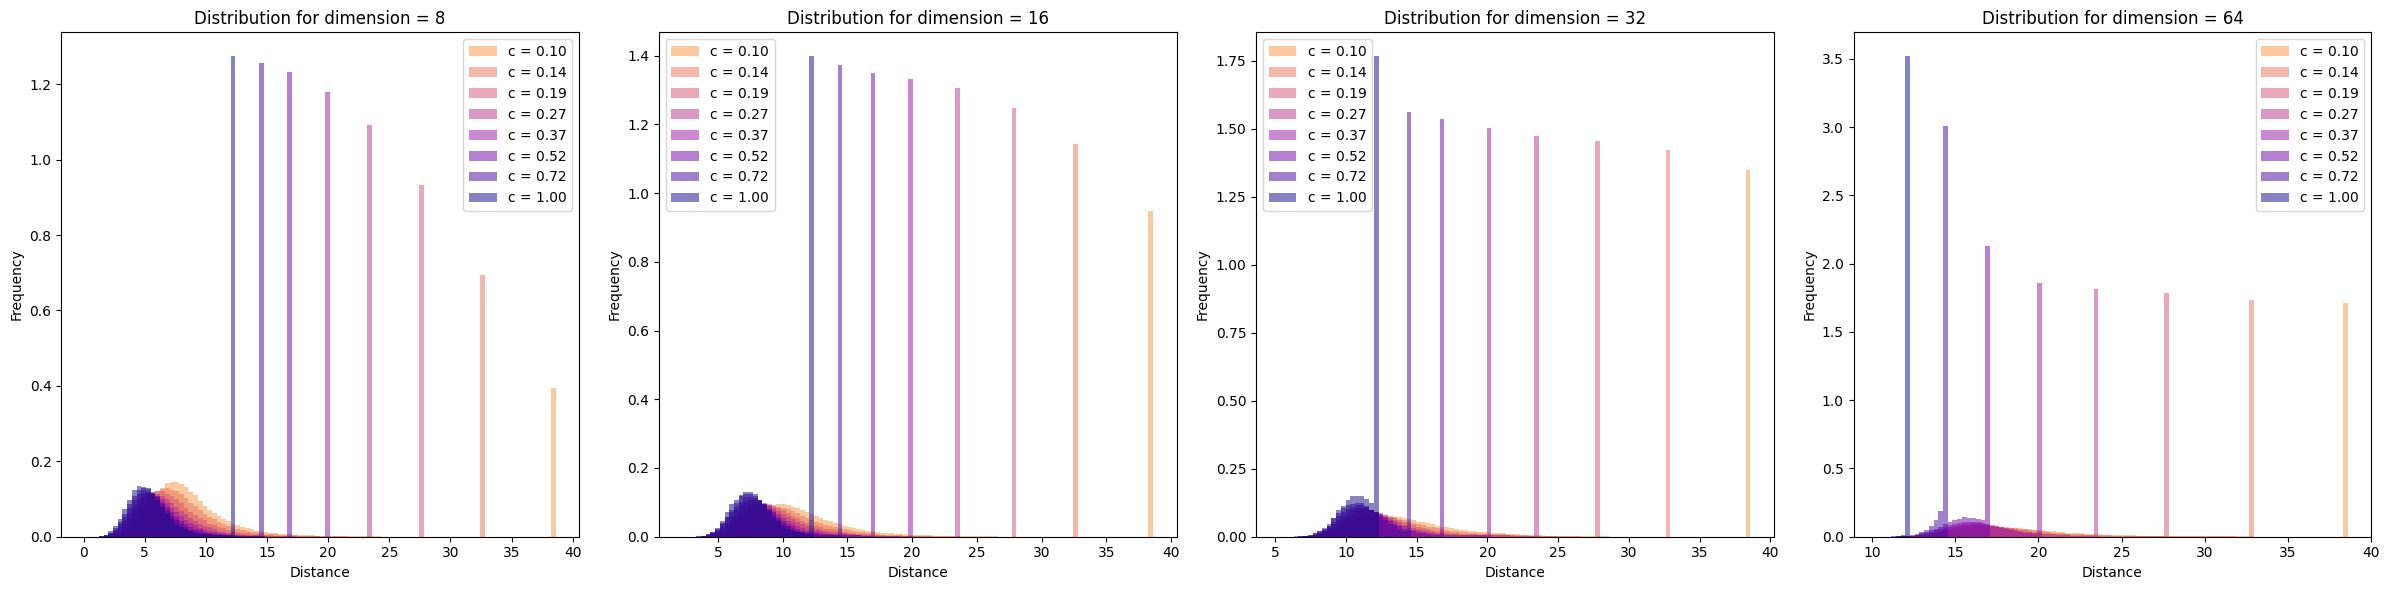

In [8]:
dimensions = [8, 16, 32, 64]
curvatures = np.logspace(-1, 0, 8)

# Create a figure with subplots. Since we have 3 dimensions, we create 3 subplots in a 1x3 grid.
fig, axes = plt.subplots(1, len(dimensions), figsize=(24, 6))

# Check if we have more than one axis (which happens if len(dimensions) > 1)
# If so, iterate over them, otherwise, wrap the single axis in a list for consistent handling
if not isinstance(axes, np.ndarray):
    axes = [axes]

for ax, d in zip(axes.flat, dimensions):
    B, T, C = 64, 64, d
    
    # Preparing to collect all distances for different curvatures
    all_dists = []  # This will hold all distance arrays for current dimension
    labels = []  # This will hold labels for the histograms
    
    for c in curvatures:
        x = pmath.expmap0(torch.randn(B, T, C), c=c)  
        y = pmath.expmap0(torch.randn(B, T, C), c=c)  
        dists = pmath.dist_matrix(x, y, c=c).view(-1).cpu().numpy()
        all_dists.append(dists)
        labels.append(f'c = {c:.2f}')

    # Plotting the histograms for all curvatures in the current subplot
    n = len(curvatures)
    colors = plt.cm.plasma(np.linspace(0.75, 0., n))
    bins = np.histogram_bin_edges(np.concatenate(all_dists), bins=100)
    for dists, label, color in zip(all_dists, labels, colors):
        ax.hist(dists, bins=bins, alpha=0.5, label=label, color=color, density=True)

    ax.set_title(f'Distribution for dimension = {d}')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()  
plt.savefig('out/dist_over_higher_dimensions.jpg')
plt.show()

##### мажем гауссиану

In [7]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x)) # Task: look at softmax distributions

In [11]:
distances = {}

B, T, C = 64, 128, 2
x = torch.randn(B, T, C)
y = torch.randn(B, T, C)

# x_flat = x.view(B * T, C)  
# y_flat = y.view(B * T, C) 
scalar_products = torch.matmul(x, y.transpose(-2,-1))
scalar_products = scalar_products / torch.sqrt(torch.tensor(2.0))
distances['Scalar Product'] = scalar_products.view(-1).cpu().numpy() / torch.sqrt(torch.tensor(2.))

x = pmath.expmap0(x)
y = pmath.expmap0(y)
distances['Hyperbolic, c = 0.35'] = pmath.dist_matrix(x, y, c=0.35).view(-1).cpu().numpy()
distances['Hyperbolic, c = 0.01'] = pmath.dist_matrix(x, y, c=0.01).view(-1).cpu().numpy()
distances['Hyperbolic, c = 0.6'] = pmath.dist_matrix(x, y, c=0.6).view(-1).cpu().numpy()

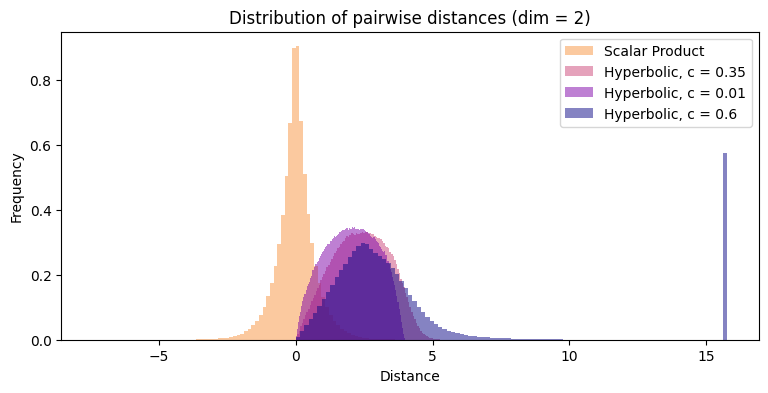

In [12]:
colors = cmap = plt.cm.plasma(np.linspace(0.75, 0., 4))

plt.figure(figsize=(9, 4))
for l, dists, color in zip(distances.keys(), distances.values(), colors):
    plt.hist(dists, bins=100, alpha=0.5, label=l, color=color, density=True)
plt.title('Distribution of pairwise distances (dim = 2)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('compared_distances.jpg')
plt.show()

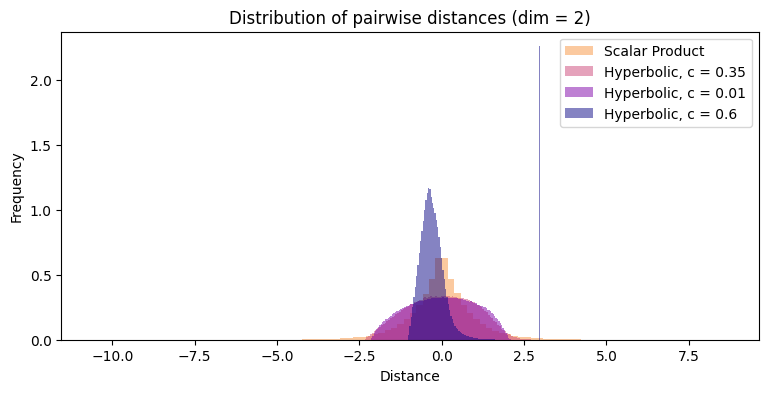

In [13]:
colors = cmap = plt.cm.plasma(np.linspace(0.75, 0., 4))

plt.figure(figsize=(9, 4))
for l, dists, color in zip(distances.keys(), distances.values(), colors):
    dists -= dists.mean()
    dists = dists / dists.std()
    plt.hist(dists, bins=100, alpha=0.5, label=l, color=color, density=True)
plt.title('Distribution of pairwise distances (dim = 2)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('compared_distances.jpg')
plt.show()

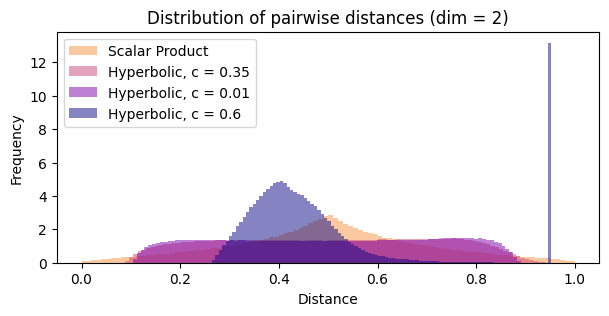

In [14]:
colors = cmap = plt.cm.plasma(np.linspace(0.75, 0., 4))

plt.figure(figsize=(7, 3))
for l, dists, color in zip(distances.keys(), distances.values(), colors):
    dists -= dists.mean()
    dists = dists / dists.std()
    sigmoids = sigmoid(dists)
    plt.hist(sigmoids, bins=100, alpha=0.5, label=l, color=color, density=True)
plt.title('Distribution of pairwise distances (dim = 2)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()